In [1]:
import numpy as np
import scipy.io as scio
from sklearn.decomposition import PCA
import pickle
from math_plds import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [2]:
nld = 4
nts = 6187
nn = 300
nsd = 4
data = scio.loadmat('../data/compiled_dF033016.mat')
frameHz = data['FrameRateHz'][0, 0]  # frames per seconds
y = data['behavdF'].T
onsetframe = data['onsetFrame'].T[0]
onsettime = np.array(data['onsetFrame'].T[0]) / frameHz

resptime = data['resptime'].T[0]
correct = data['correct'][0]

offsettime = onsettime + resptime + 2.75 + (4.85 - 2.75) * (1 - correct)
offsetframe = (offsettime * frameHz).astype(np.int32)

orientation = np.array(data['orient'][0], np.int8)
location = np.array((data['location'][0] + 1) // 2, np.int8)

u = np.zeros((y.shape[0], nsd))
for onf, off, ori, loc in zip(onsetframe, offsetframe, orientation, location):
    for frame in np.arange(onf, off, dtype=np.int32):
        u[frame] = np.array([ori*loc, (1-ori)*loc, ori*(1-loc), (1-ori)*(1-loc)])

stimuli = 1 * (1 - orientation) * location + 2 * orientation * (1 - location) + 3 * (1 - orientation) * (1 - location)

stimulicross = stimuli[np.where(offsetframe > y.shape[0] - nts)[0][0]:]
crossoffsetframe = offsetframe[-len(stimulicross):]-20000
ycross = y.flatten()[-nts*nn:]
ucross = u.flatten()[-nts*nsd:]

uvec = u[-nts:]


In [3]:
estimates = pickle.load(open('../outputs/pldsrun_2018-3-11-1-19_nld=4.pldsop', 'rb'))
A = estimates['A']
B = estimates['B']
C = estimates['C']
d = estimates['d']
m0 = estimates['m0']
Q = estimates['Q']
Q0 = estimates['Q0']

In [4]:
mu0 = np.random.randn(ycross.shape[0]//nn * nld)
mu, covd, covod = laplace_approximation(logposterior(ycross, C, d, A, B, Q, Q0, m0, ucross, nts, nn, nsd, nld),
                                                logposteriorderivative(ycross, C, d, A, B, Q, Q0, m0, ucross, nts, nn, nsd, nld),
                                                logposteriorhessian(C, d, A, Q, Q0, nts, nn, nld),
                                                mu0, nts, nld)
muvec = mu.reshape(-1, nld)


computing covariance


In [7]:
stimgroups = {str(i):[] for i in range(nsd)}
for stim, off in zip(stimulicross, crossoffsetframe):
    stimgroups[str(stim)].append(muvec[off - 10: off + 20])
stimgroups = {str(i):np.array(stimgroups[str(i)]) for i in range(nsd)}
    

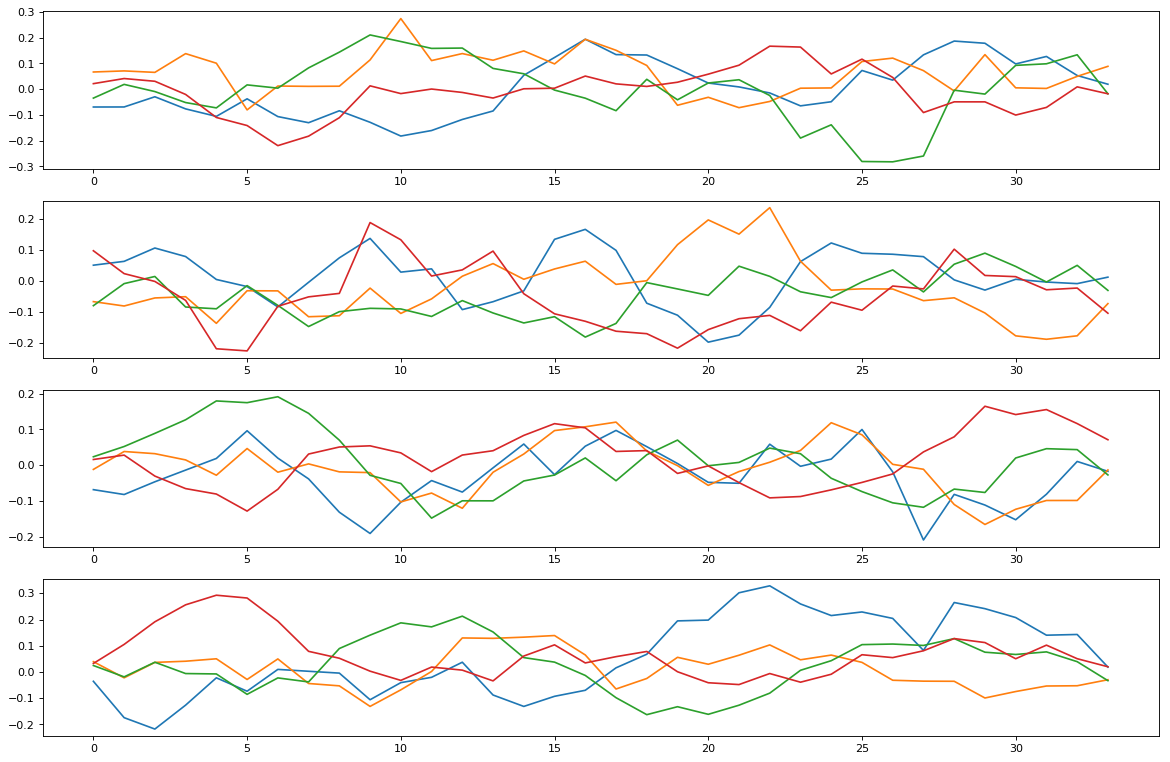

In [8]:
plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
for j in range(nsd):
    plt.subplot(nsd, 1, j+1)
    for i in range(nld):
        smth = np.convolve(np.mean(stimgroups[str(j)], axis=0).T[i],  .2*np.ones(5))
        plt.plot(smth)
plt.show()

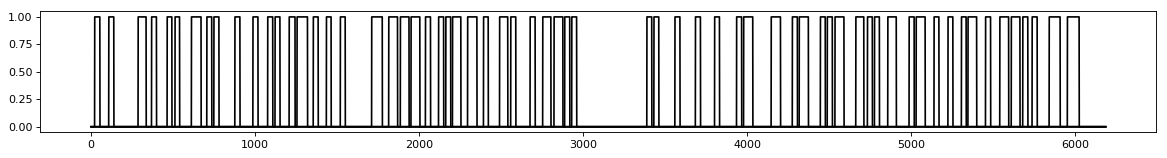

In [9]:
plt.figure(figsize=(18, 2), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(uvec, 'k')
plt.show()

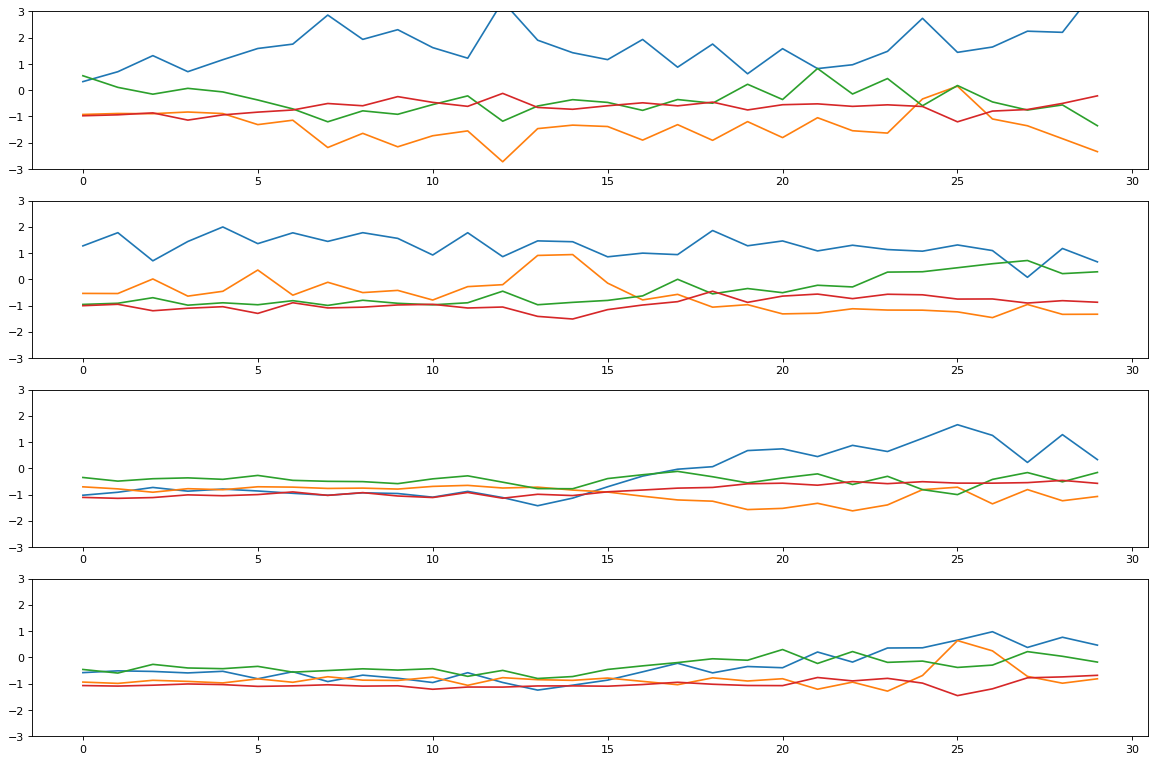

In [10]:
pca = PCA(n_components=nld)
pca.fit(y[:-nts])
reducedy = pca.transform(y[-nts:])

pcastimgroups = {str(i):[] for i in range(nsd)}
for stim, off in zip(stimulicross, crossoffsetframe):
    pcastimgroups[str(stim)].append(reducedy[off - 10: off + 20])

plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
for j in range(nsd):
    plt.subplot(nsd, 1, j+1)
    for i in range(nld):
        smth = np.mean(pcastimgroups[str(j)], axis=0).T[i]
        plt.plot(smth)
        plt.ylim(-3, 3)
plt.show()

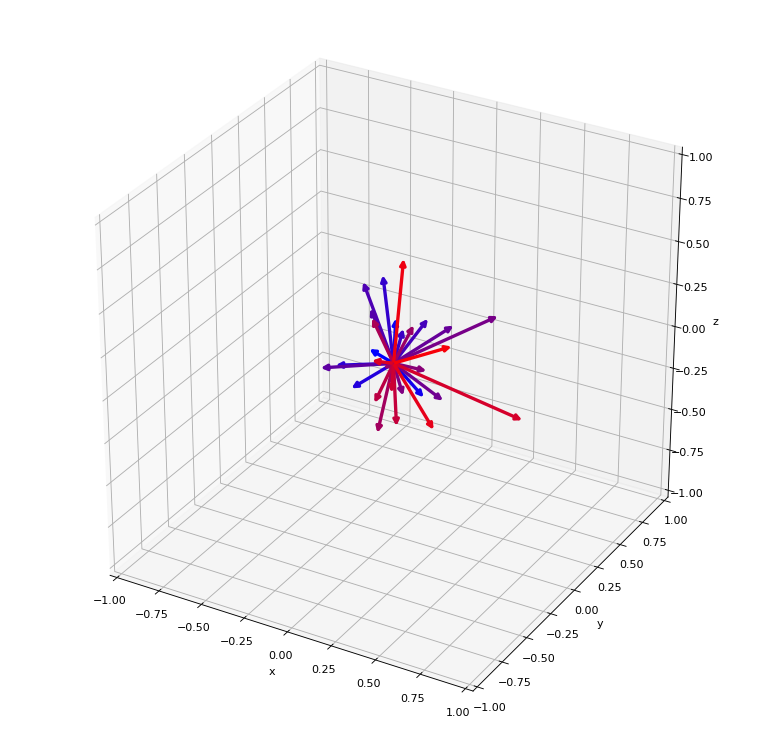

In [16]:
# vectors = np.array([[0,0,0,1,-2,0]])
def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return r/255., g/255., b/255.

vectors = [np.mean(stimgroups['0'][:,t], axis=0) for t in range(0,30)]
fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
for i, v in enumerate(vectors):
    vlength=np.linalg.norm(v)
    a = Arrow3D([0, v[0]], [0, v[1]], 
                [0, v[2]], mutation_scale=10, 
                lw=3, arrowstyle="-|>", color=(i/30., 0, (30 - i)/30. ))
    ax.add_artist(a)
#     ax.quiver(0,0,0,vector[0],vector[1],vector[2], pivot='tail',length=vlength, arrow_length_ratio=2./vlength)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [120]:
np.mean(stimgroups['0'][:,0], axis=0)


array([ 0.17607263, -0.20092888,  0.24223778,  0.47336681])